Run 1
RMSE for run 1: {1: 327.3743854101975, 2: 624.7317732630715, 3: 706.5971594538032, 4: 730.0874242705084, 5: 777.0788002961064}
Run 2
RMSE for run 2: {1: 334.46037725349726, 2: 586.3571337226581, 3: 703.8932863830031, 4: 733.2158536201359, 5: 743.4036171617952}
Run 3
RMSE for run 3: {1: 330.5280974576028, 2: 582.3848774975751, 3: 699.5984697844043, 4: 729.7751520997535, 5: 775.9172778303026}
Run 4
RMSE for run 4: {1: 349.7654459069699, 2: 605.3842275178299, 3: 688.9912104865937, 4: 769.9033168041803, 5: 758.9307032981743}
Run 5
RMSE for run 5: {1: 325.7336398658722, 2: 593.2089197401095, 3: 677.8692682190043, 4: 721.9774579081147, 5: 739.098443496712}
Run 6
RMSE for run 6: {1: 332.6688577055924, 2: 590.3934486360491, 3: 698.5706302811576, 4: 757.4953104251425, 5: 739.8103824424612}
Run 7
RMSE for run 7: {1: 344.9465493846525, 2: 589.3861199286023, 3: 671.5343885599938, 4: 739.3310289388767, 5: 751.335154575683}
Run 8
RMSE for run 8: {1: 372.9664640055938, 2: 567.8216413540256, 3: 

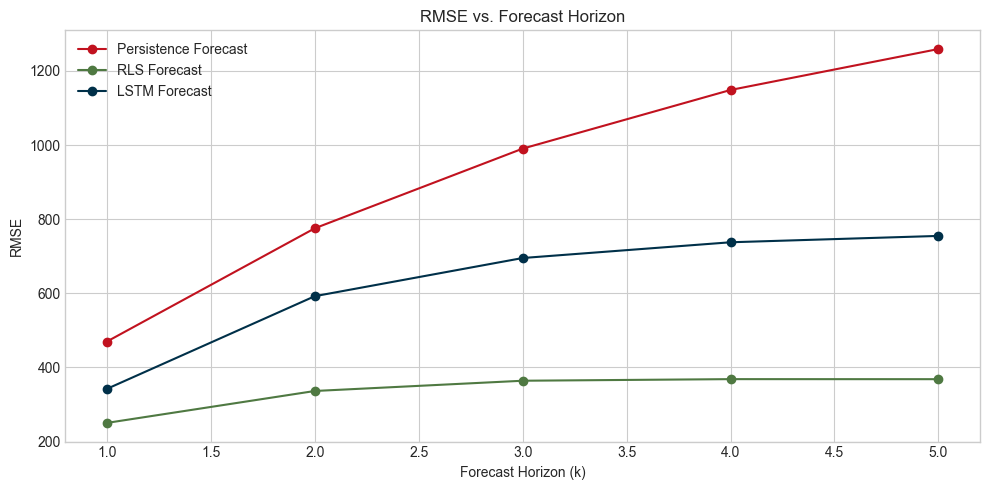

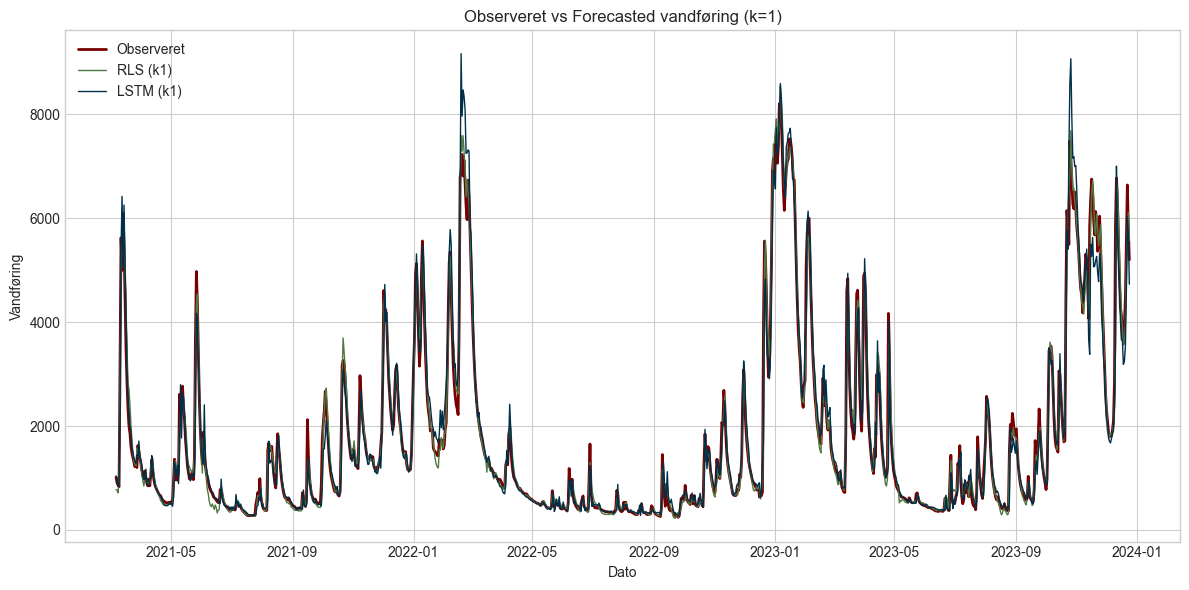

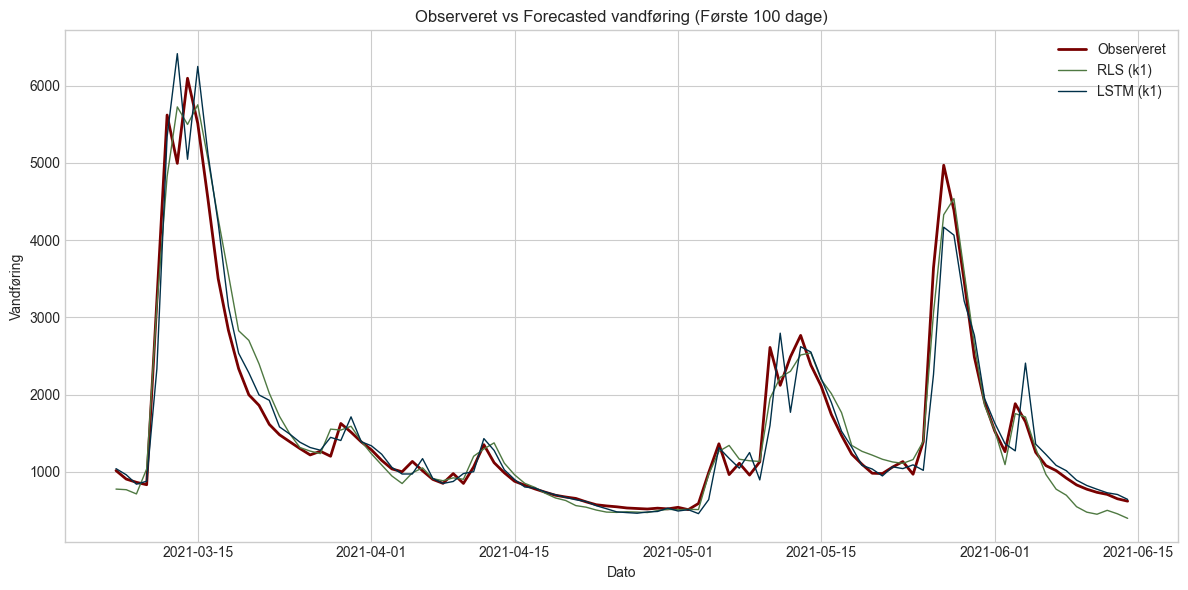

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

##########################################
# Global Settings
##########################################
plt.style.use('seaborn-v0_8-whitegrid')
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "fern_green": "#4F7942",
    "light_fern_green": "#84A17B",
    "muted_purple": "#6A4C93",
    "beaver": "#9F7E69",
    "dun": "#D2BBA0",
    "prussian_blue": "#003049",
    "air_superiority_blue": "#669bbc"
}

##########################################
# Helper Functions
##########################################
def low_pass(series, a1):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

def persistence(df, horizons):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        forecasts[f'k{k}'] = df['y'].shift(1)
    return forecasts

def score(residuals, mask=None):
    if mask is not None:
        residuals = residuals[mask]
    return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    fig, ax = plt.subplots(figsize=(10, 5))
    model_colors = {
        "Persistence Forecast": colors["fire_brick"],
        "RLS Forecast": colors["fern_green"],
        "LSTM Forecast": colors["prussian_blue"]
    }
    for model_name, rmse in rmse_dict.items():
        ax.plot(horizons, rmse.values, marker='o', label=model_name,
                color=model_colors.get(model_name, 'black'))
    ax.set_xlabel("Forecast Horizon (k)")
    ax.set_ylabel("RMSE")
    ax.set_title("RMSE vs. Forecast Horizon")
    ax.legend()
    plt.tight_layout()
    plt.show()

def rls_fit(X, y, lam=0.9, delta=1000):
    n_obs, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    yhat = np.full(n_obs, np.nan)
    for t in range(n_obs):
        x_t = X[t, :].reshape(-1, 1)
        if np.any(np.isnan(x_t)) or np.isnan(y[t]):
            continue
        denom = lam + (x_t.T @ P @ x_t).item()
        K = (P @ x_t) / denom
        error = y[t] - (x_t.T @ theta).item()
        theta = theta + (K.flatten() * error)
        P = (P - K @ x_t.T @ P) / lam
        yhat[t] = float(X[t, :] @ theta)
    return theta, yhat

def fit_rls_forecast(df, lam=0.9, a1=0.9, horizons=[1,2,3,4,5]):
    forecasts = pd.DataFrame(index=df.index)
    for k in horizons:
        bias = pd.Series(1, index=df.index, name='bias')
        inflow_pred = df['y'].shift(1)
        temp_pred = df['temp_mean_daily'].shift(-(k-1))
        precip_pred = df['precip_total_daily'].shift(-(k-1))
        precip_lp = low_pass(precip_pred, a1)
        X = pd.concat([bias, inflow_pred, temp_pred.rename('temp'), precip_lp.rename('precip')], axis=1)
        y_target = df['y'].shift(-(k-1))
        valid = X.notna().all(axis=1) & y_target.notna()
        theta, yhat = rls_fit(X.loc[valid].to_numpy(), y_target.loc[valid].to_numpy(), lam=lam)
        series = pd.Series(np.nan, index=df.index)
        series.loc[valid] = yhat
        forecasts[f'k{k}'] = series
    return forecasts

##########################################
# Data Loading and Cleaning
##########################################
data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv"
D = pd.read_csv(data_path)
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()
D_time_indexed.loc[D_time_indexed['temp_mean_daily'] > 35, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)
D_time_indexed.loc[D_time_indexed['precip_total_daily'] > 100, 'precip_total_daily'] = 0

# Create forecast columns
D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = low_pass(D_time_indexed['precip_total_daily'], a1=0.9)
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

# Define score period
score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]

##########################################
# Compute Persistence and RLS Forecasts
##########################################
horizons = [1,2,3,4,5]
YhatP = persistence(D_time_indexed, horizons)
YhatR = fit_rls_forecast(D_time_indexed)

# Compute RMSEs
mask = D_time_indexed.index.isin(score_period)
targets = {k: D_time_indexed['y'].shift(-(k-1)) for k in horizons}
rmse_P = pd.Series({f'k{k}': score(YhatP[f'k{k}'] - targets[k], mask) for k in horizons})
rmse_R = pd.Series({f'k{k}': score(YhatR[f'k{k}'] - targets[k], mask) for k in horizons})

##########################################
# LSTM MSE-Only Model with Multiple Runs
##########################################
def create_offline_dataset_horizon(df, window_size, k, a1=0.9):
    X_hist, X_fcst, y_list, idxs = [], [], [], []
    for i in range(window_size, len(df) - (k - 1)):
        date = df.index[i + (k - 1)]
        hist = df.iloc[i - window_size:i][['y','temp_mean_daily','precip_total_daily']].values.astype(np.float32)
        fcst = np.array([
            df.iloc[i + (k - 1)]['temp_forecast'],
            df.iloc[i + (k - 1)]['precip_forecast'],
            np.sin(2*np.pi*date.dayofyear/365),
            np.cos(2*np.pi*date.dayofyear/365)
        ], dtype=np.float32)
        X_hist.append(hist)
        X_fcst.append(fcst)
        y_list.append(float(df.iloc[i + (k - 1)]['y']))
        idxs.append(date)
    return np.array(X_hist), np.array(X_fcst), np.array(y_list), np.array(idxs)

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def build_offline_model(window_size, loss_fn=mse_loss):
    hist_in = Input(shape=(window_size, 3))
    x = LSTM(64, activation='relu')(hist_in)
    x = Dense(64, activation='relu')(x)
    fcst_in = Input(shape=(4,))
    y = Dense(32, activation='relu')(fcst_in)
    y = Dense(32, activation='relu')(y)
    combined = Concatenate()([x, y])
    combined = Dense(64, activation='relu')(combined)
    out = Dense(1, activation='linear')(combined)
    model = Model(inputs=[hist_in, fcst_in], outputs=out)
    model.compile(optimizer=Adam(0.001), loss=loss_fn)
    return model

window_size = 10
runs = 10
all_rmse = []
final_lstm_forecasts = {}

for run in range(1, runs+1):
    print(f"Run {run}")
    lstm_forecasts = {}
    rmse_L = {}
    for k in horizons:
        Xh, Xf, y, idxs = create_offline_dataset_horizon(D_time_indexed, window_size, k)
        train_mask = idxs < score_start
        test_mask = idxs >= score_start
        Xh_train, Xf_train, y_train = Xh[train_mask], Xf[train_mask], y[train_mask]
        Xh_test, Xf_test, y_test, idx_test = Xh[test_mask], Xf[test_mask], y[test_mask], idxs[test_mask]
        if len(y_test) == 0:
            continue
        model = build_offline_model(window_size)
        model.fit([Xh_train, Xf_train], y_train,
                  validation_split=0.2, epochs=100, batch_size=32,
                  verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
        preds = model.predict([Xh_test, Xf_test], verbose=0).flatten()
        lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idx_test)
        rmse_L[k] = np.sqrt(np.nanmean((y_test - preds)**2))
    if run == runs:
        final_lstm_forecasts = lstm_forecasts.copy()
    rmse_series = pd.Series(rmse_L)
    print(f"RMSE for run {run}:", rmse_series.to_dict())
    all_rmse.append(rmse_series)

# Average RMSE across runs
avg_rmse = pd.concat(all_rmse, axis=1).mean(axis=1)
print("Average RMSE across runs:", avg_rmse.to_dict())

##########################################
# Plotting Average RMSE
##########################################
rmse_dict = {
    'Persistence Forecast': rmse_P,
    'RLS Forecast': rmse_R,
    'LSTM Forecast': avg_rmse
}
plot_rmse(rmse_dict, horizons)

##########################################
# Plot Actual vs Predicted for k=1 (Final Run)
##########################################
data_test = D_time_indexed.loc[score_period]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data_test.index, data_test['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
ax.plot(data_test.index, YhatR.loc[data_test.index,'k1'], label='RLS (k1)', color=colors['fern_green'], linewidth=1)
ax.plot(final_lstm_forecasts['k1'].reindex(data_test.index), label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
ax.set_xlabel('Dato')
ax.set_ylabel('Vandføring')
ax.set_title('Observeret vs Forecasted vandføring (k=1)')
ax.legend()
plt.tight_layout()
plt.show()

# First 100 days of test set
short = data_test.iloc[:100]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(short.index, short['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
ax.plot(short.index, YhatR.loc[short.index,'k1'], label='RLS (k1)', color=colors['fern_green'], linewidth=1)
ax.plot(short.index, final_lstm_forecasts['k1'].reindex(short.index), label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
ax.set_xlabel('Dato')
ax.set_ylabel('Vandføring')
ax.set_title('Observeret vs Forecasted vandføring (Første 100 dage)')
ax.legend()
plt.tight_layout()
plt.show()


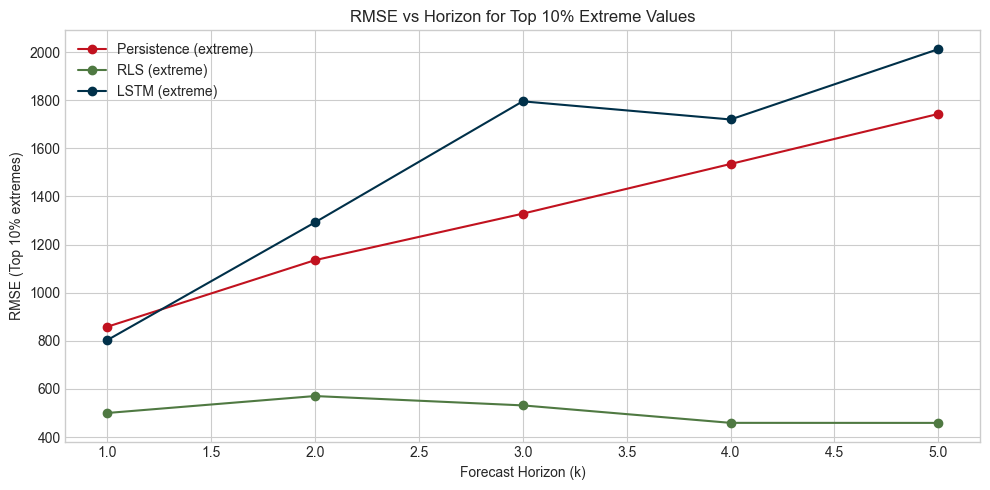

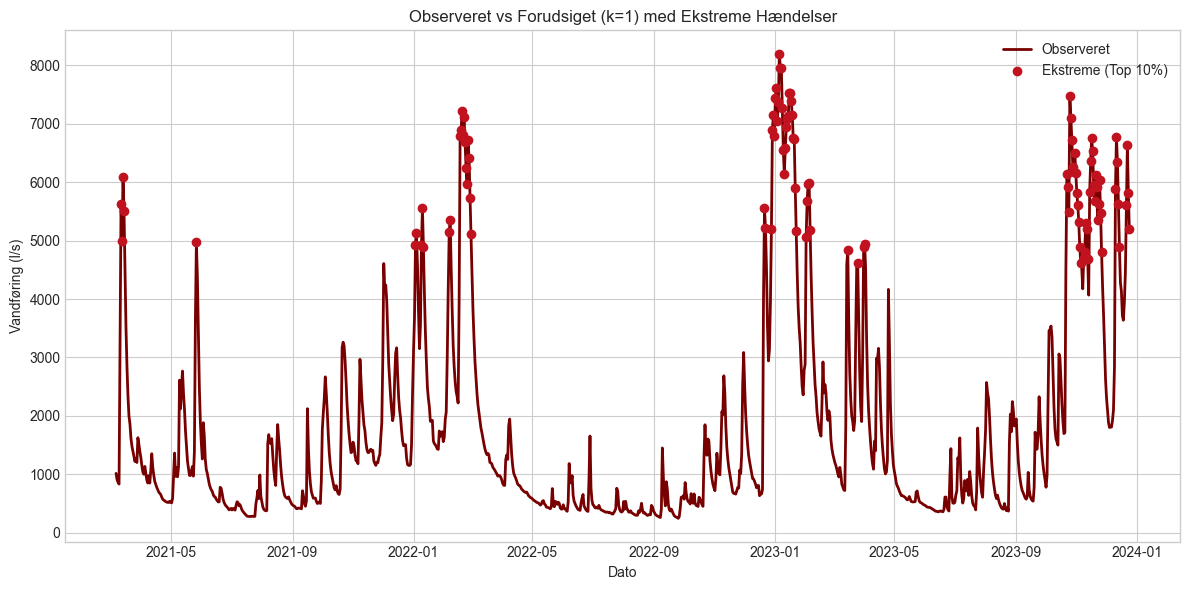

In [19]:
##########################################
# RMSE for Top 10% Extreme Values
##########################################
threshold = np.percentile(D_time_indexed.loc[score_period, 'y'], 90)
mask_extreme = D_time_indexed['y'].ge(threshold) & D_time_indexed.index.isin(score_period)

rmse_extreme_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
rmse_extreme_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
rmse_extreme_L = pd.Series({k: score(final_lstm_forecasts[f'k{k}'].reindex(D_time_indexed.index) - targets[k], mask_extreme) for k in horizons})

# Plot RMSE for extremes
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, rmse_extreme_P.values, marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
ax.plot(horizons, rmse_extreme_R.values, marker='o', label='RLS (extreme)', color=colors['fern_green'])
ax.plot(horizons, rmse_extreme_L.values, marker='o', label='LSTM (extreme)', color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('RMSE (Top 10% extremes)')
ax.set_title('RMSE vs Horizon for Top 10% Extreme Values')
ax.legend()
plt.tight_layout()
plt.show()

##########################################
# Actual vs. Predicted (Score Period, Horizon 1) - Highlight Extreme Events
##########################################
threshold = np.percentile(D_time_indexed.loc[score_period, 'y'], 90)
score_data = D_time_indexed.loc[score_period]
extreme_mask = score_data['y'] >= threshold

plt.figure(figsize=(12, 6))
plt.plot(score_data.index, score_data['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
# plt.plot(score_data.index, YhatR.loc[score_data.index, 'k1'], label='RLS Forudsigelse (k1)', color=colors['fern_green'], linewidth=1)
plt.scatter(score_data.index[extreme_mask], score_data['y'][extreme_mask],
            color=colors['fire_brick'], label='Ekstreme (Top 10%)', zorder=5)
plt.xlabel('Dato')
plt.ylabel('Vandføring (l/s)')
plt.title('Observeret vs Forudsiget (k=1) med Ekstreme Hændelser')
plt.legend()
plt.tight_layout()
plt.show()


CSI for Persistence Forecasts: [0.7226890756302521, 0.553030303030303, 0.4642857142857143, 0.3945578231292517, 0.3576158940397351]
CSI for RLS Forecasts: [0.8378378378378378, 0.7798165137614679, 0.7289719626168224, 0.719626168224299, 0.7358490566037735]
CSI for LSTM Forecasts: [0.8198198198198198, 0.575, 0.4344262295081967, 0.4, 0.40476190476190477]


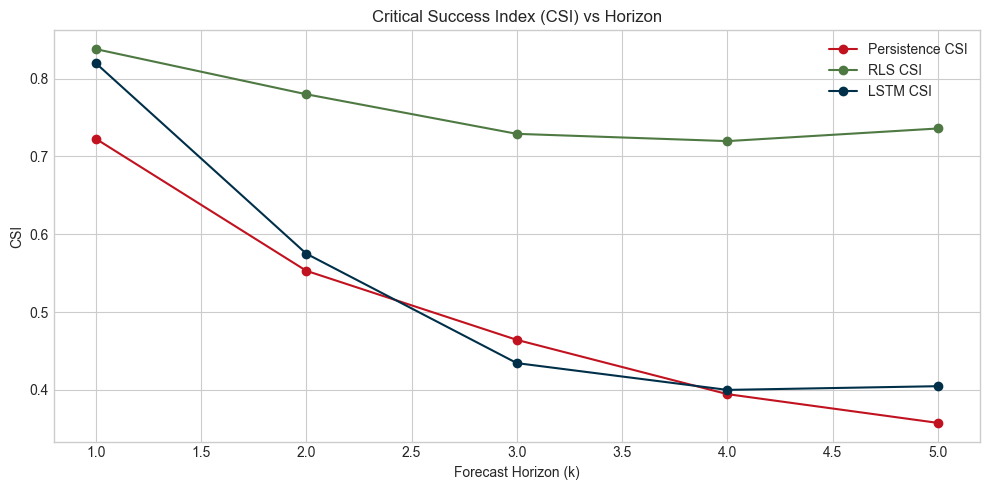

In [20]:
##########################################
# Compute and Plot CSI for Each Model
##########################################
# Define CSI function for binary events
def compute_csi(y_true, y_pred, threshold):
    # Binary events: 1 if value >= threshold, else 0
    obs = (y_true >= threshold).astype(int)
    pred = (y_pred >= threshold).astype(int)
    tp = np.sum((obs == 1) & (pred == 1))
    fn = np.sum((obs == 1) & (pred == 0))
    fp = np.sum((obs == 0) & (pred == 1))
    # CSI = TP / (TP + FN + FP)
    return tp / (tp + fn + fp) if (tp + fn + fp) > 0 else np.nan

# Calculate CSI across horizons
csi_P = []
csi_R = []
csi_L = []
for k in horizons:
    # Observed and forecasts for horizon k on score period
    y_obs = D_time_indexed['y'].shift(-(k-1)).loc[score_period]
    y_pred_P = YhatP[f'k{k}'].loc[score_period]
    y_pred_R = YhatR[f'k{k}'].loc[score_period]
    y_pred_L = final_lstm_forecasts[f'k{k}'].reindex(score_period)
    # compute CSI for each
    csi_P.append(compute_csi(y_obs.values, y_pred_P.values, threshold))
    csi_R.append(compute_csi(y_obs.values, y_pred_R.values, threshold))
    csi_L.append(compute_csi(y_obs.values, y_pred_L.values, threshold))


# Print out values
print("CSI for Persistence Forecasts:", csi_P)
print("CSI for RLS Forecasts:", csi_R)
print("CSI for LSTM Forecasts:", csi_L)

# Plot CSI vs Horizon
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, csi_P, marker='o', label='Persistence CSI', color=colors['fire_brick'])
ax.plot(horizons, csi_R, marker='o', label='RLS CSI', color=colors['fern_green'])
ax.plot(horizons, csi_L, marker='o', label='LSTM CSI', color=colors['prussian_blue'])
ax.set_xlabel('Forecast Horizon (k)')
ax.set_ylabel('CSI')
ax.set_title('Critical Success Index (CSI) vs Horizon')
ax.legend()
plt.tight_layout()
plt.show()